In [1]:
import numpy as np
import pycycle as cy
import matplotlib.pyplot as plt
import scipy
%load_ext autoreload
%autoreload 2
%matplotlib notebook

Mesh creation
===========

In [2]:
b1 = (0, 40.0)
b2 = (0, 50.0)
h1 = 0.2
h2 = 1.0
star_centre = (1, 1)
normal1 = cy.mesh.line_normal((0, 0), b1, star_centre)
normal2 = cy.mesh.line_normal(b1, b2, star_centre)

# Create a mesh from origin to b1 with resolution h1
# True means on-fault
mesh = cy.mesh.tessellate_line((0, 0), b1, h1, normal1, True)
# Add a mesh from b1 to b2 with resolution h2
mesh = mesh + cy.mesh.tessellate_line(b1, b2, h2, normal2)
# Extend to infinity
mesh.append(cy.mesh.InfiniteLineElement(b2, normal2))

Parameters
==========

In [5]:
rho = 2.670   # density [g/m^3]
v_s = 3.464   # shear wave velocity [km/s]
Vp = 1e-9     # plate rate [m/s]
V0 = 1e-6     # reference slip rate [m/s]
b = 0.015     # b parameter
L = 0.008     # critical slip distance [m]
f0 = 0.6      # reference friction coefficient
sn = 50       # normal stress [MPa]
Vinit = 1e-9  # initial slip rate [m/s]
cp = cy.seas.ConstantParams(rho, v_s, Vp, V0, b, L, f0, sn, Vinit)

In [6]:
a0 = 0.010
amax = 0.025
# a parameter depends on x
def a(x):
    z = x[1]
    H = 15.0
    h = 3.0
    if z < H:
        return a0
    elif z < H + h:
        return a0 + (amax - a0) * (z - H) / h
    else:
        return amax

# pre-stress may depend on position, constant here
def tau_pre(x):
    e = np.exp((f0 + b * np.log(V0 / Vinit)) / amax)
    return -(sn * amax * np.arcsinh((Vinit / (2.0 * V0)) * e) + cp.eta * Vinit)

vp = cy.seas.VariableParams(mesh, a, tau_pre)

Compile
==========

In [7]:
# initialize solver context
ctx = cy.seas.Context(mesh, cy.green.G_fs, cy.green.dG_fs_dn, vp, cp)

/import/freenas-m-04-students/fkutschera/Master/P10/P10_NDiES/SEAS/pycycle-student/pycycle/bem.py:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  A[i, j] = quad(K, -1, 0)[0] + quad(K, 0, 1)[0]


Plot setup
========

<IPython.core.display.Javascript object>


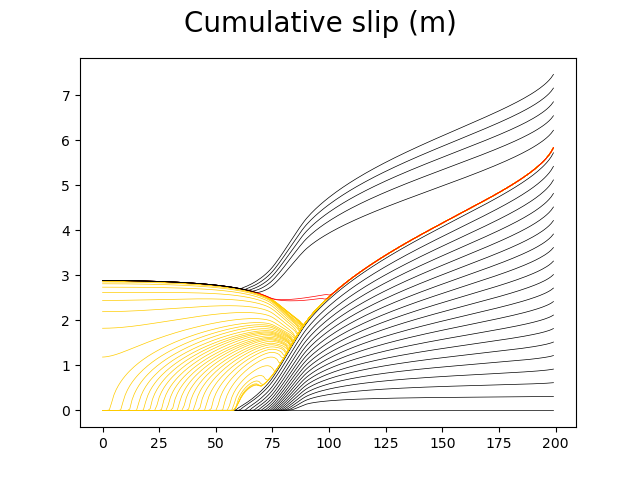

In [8]:
u_fig = plt.figure()

# fig.canvas.set_window_title('Canvas active title')
u_fig.suptitle('Cumulative slip (m)', fontsize=20)

# Create plots inside the figures
u_ax = u_fig.add_subplot(111)

<IPython.core.display.Javascript object>


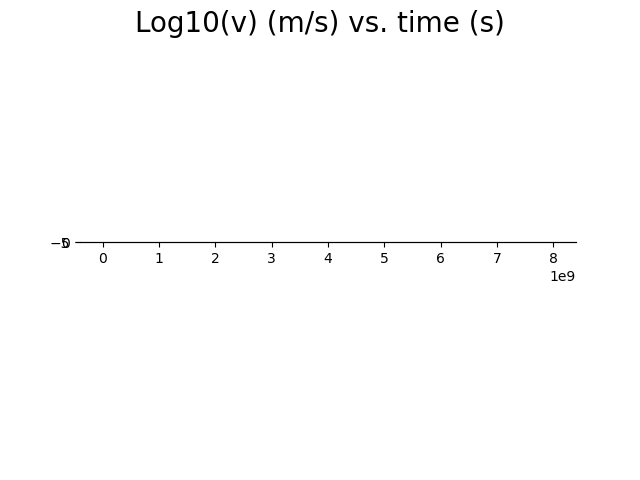

In [9]:
v_fig = plt.figure()

# fig.canvas.set_window_title('Canvas active title')
v_fig.suptitle('Log10(v) (m/s) vs. time (s)', fontsize=20)

# Create plots inside the figures
v_ax = v_fig.add_subplot(111)

In [10]:
thresholds = [
    {'color': '#000000', 'vthresh': 0,     'dt': 10*365*24*60*60, 'interval': '10 years' },
    {'color': '#ff0000', 'vthresh': 1e-06, 'dt': 24*60*60,        'interval': '1  day'   },
    {'color': '#ffcc00', 'vthresh': 1e-02, 'dt': 1,               'interval': '1  second'}
]

Initial conditions
=============

In [17]:
y0 = cy.seas.y0(ctx) # initial condition

In [20]:
t0 = 0
tend = 8e9 # in secdonds
tend_years = tend/60/60/24/365
print(tend_years)

253.67833587011665


Solve
=====

In [19]:
monitor = cy.monitor.Monitor(thresholds, u_ax, u_fig, v_ax, v_fig)

def F(t, y, ctx):
    # a new step begins, take y to represent the result of last step.
    fresh = t == F.t_
    F.t_  = t
    return cy.seas.F(t,y,ctx,monitor) if fresh else cy.seas.F(t,y,ctx)
F.t_ = t0

result = scipy.integrate.solve_ivp( F, (t0, tend), y0, method='RK45', rtol=1e-7, atol=1e-7, args=(ctx,), first_step=100) #, max_step=60*60*24*365

     0 yr,   0 d,  0 h,  0 m,  0 s,   0 ms.
       v_max =  1.0000000000000036e-09 m/s |  3.153600000000011 cm/yr
     0 yr,   0 d,  0 h,  1 m, 40 s,   0 ms.
       v_max =  9.999999999144264e-10 m/s |  3.153599999730135 cm/yr
     0 yr,   0 d,  0 h, 18 m, 20 s,   0 ms.
       v_max =  9.999999905923753e-10 m/s |  3.153599970332115 cm/yr
     0 yr,   0 d,  1 h, 33 m, 55 s,  60 ms.
       v_max =  9.999998242084136e-10 m/s |  3.153599445623653 cm/yr
     0 yr,   0 d,  3 h, 10 m, 42 s, 120 ms.
       v_max =  9.99999466387497e-10 m/s |  3.153598317199611 cm/yr
     0 yr,   0 d,  5 h, 33 m, 32 s, 180 ms.
       v_max =  9.99998817201735e-10 m/s |  3.1535962699273914 cm/yr
     0 yr,   0 d,  8 h, 57 m, 57 s, 776 ms.
       v_max =  9.999977800322972e-10 m/s |  3.1535929991098524 cm/yr
     0 yr,   0 d, 13 h, 52 m, 22 s, 719 ms.
       v_max =  9.999961873297204e-10 m/s |  3.1535879763630064 cm/yr
     0 yr,   0 d, 20 h, 55 m, 53 s, 396 ms.
       v_max =  9.999938005368385e-10 m/s |  3.153

    31 yr,  56 d, 18 h, 57 m, 12 s, 898 ms.
       v_max =  9.547734890681095e-10 m/s |  3.0109736751251903 cm/yr
    31 yr, 351 d,  8 h, 24 m, 19 s, 111 ms.
       v_max =  9.5453883285724e-10 m/s |  3.0102336632985924 cm/yr
    31 yr, 306 d, 13 h, 35 m,  9 s, 663 ms.
       v_max =  9.545444799000309e-10 m/s |  3.0102514718127376 cm/yr
    32 yr, 191 d,  8 h, 13 m,  6 s, 427 ms.
       v_max =  9.542759712039998e-10 m/s |  3.0094047027889337 cm/yr
    33 yr, 162 d, 20 h, 46 m,  8 s, 432 ms.
       v_max =  9.539467317502483e-10 m/s |  3.0083664132475834 cm/yr
    34 yr, 115 d, 11 h, 29 m, 37 s,  89 ms.
       v_max =  9.537525012607276e-10 m/s |  3.0077538879758303 cm/yr
    35 yr,  65 d, 12 h, 55 m, 40 s, 933 ms.
       v_max =  9.535710386116217e-10 m/s |  3.0071816273656102 cm/yr
    34 yr, 346 d, 10 h, 58 m, 48 s, 512 ms.
       v_max =  9.535542980027974e-10 m/s |  3.0071288341816222 cm/yr
    35 yr, 212 d, 10 h, 27 m, 59 s, 936 ms.
       v_max =  9.533528327807347e-10 m/s |  3

    72 yr, 210 d, 14 h,  8 m,  9 s, 213 ms.
       v_max =  9.502865209714532e-10 m/s |  2.9968235725355745 cm/yr
    73 yr, 218 d,  2 h, 18 m, 55 s, 841 ms.
       v_max =  9.503508673392839e-10 m/s |  2.9970264952411654 cm/yr
    73 yr, 149 d,  1 h, 43 m, 33 s, 996 ms.
       v_max =  9.502998060739017e-10 m/s |  2.996865468434656 cm/yr
    74 yr,  87 d, 13 h, 18 m, 58 s, 779 ms.
       v_max =  9.502641961554226e-10 m/s |  2.996753168995741 cm/yr
    75 yr, 104 d, 21 h,  6 m, 52 s, 724 ms.
       v_max =  9.501641512881068e-10 m/s |  2.9964376675021733 cm/yr
    74 yr, 354 d,  3 h, 24 m,  2 s, 889 ms.
       v_max =  9.502765574374705e-10 m/s |  2.996792151534807 cm/yr
    75 yr, 255 d, 17 h, 29 m,  7 s,   0 ms.
       v_max =  9.503071183303012e-10 m/s |  2.9968885283664375 cm/yr
    76 yr, 266 d,  5 h, 46 m, 58 s,  56 ms.
       v_max =  9.50340282813916e-10 m/s |  2.9969931158819656 cm/yr
    76 yr, 209 d,  4 h, 29 m,  2 s, 154 ms.
       v_max =  9.503152418688376e-10 m/s |  2.9

   113 yr, 286 d,  4 h,  7 m, 18 s, 954 ms.
       v_max =  9.512252388605257e-10 m/s |  2.999783913270554 cm/yr
   113 yr, 228 d, 15 h, 29 m, 35 s, 348 ms.
       v_max =  9.51241463620804e-10 m/s |  2.999835079674568 cm/yr
   114 yr, 164 d, 12 h, 34 m, 43 s, 640 ms.
       v_max =  9.513173737550144e-10 m/s |  3.0000744698738133 cm/yr
   115 yr, 125 d, 23 h, 55 m, 52 s, 425 ms.
       v_max =  9.513491217071536e-10 m/s |  3.0001745902156793 cm/yr
   115 yr,  79 d, 17 h, 25 m,  7 s, 942 ms.
       v_max =  9.513306088534159e-10 m/s |  3.0001162080801325 cm/yr
   115 yr, 359 d, 22 h, 15 m, 32 s, 245 ms.
       v_max =  9.513348262460193e-10 m/s |  3.000129508049447 cm/yr
   116 yr, 302 d, 15 h, 31 m, 32 s, 723 ms.
       v_max =  9.513924226331686e-10 m/s |  3.0003111440159604 cm/yr
   117 yr, 247 d,  1 h, 30 m,  9 s, 554 ms.
       v_max =  9.51486747762284e-10 m/s |  3.000608607743138 cm/yr
   118 yr, 167 d, 16 h, 31 m, 35 s, 196 ms.
       v_max =  9.514624910808588e-10 m/s |  3.000

   161 yr, 253 d, 13 h,  2 m,  7 s, 721 ms.
       v_max =  9.54105627429575e-10 m/s |  3.0088675066619075 cm/yr
   161 yr, 220 d, 14 h,  3 m, 34 s, 749 ms.
       v_max =  9.540992296178917e-10 m/s |  3.0088473305229835 cm/yr
   162 yr, 121 d, 18 h, 57 m,  8 s,  11 ms.
       v_max =  9.541507554110263e-10 m/s |  3.0090098222642125 cm/yr
   163 yr,  23 d,  1 h, 37 m, 35 s, 899 ms.
       v_max =  9.5420307981722e-10 m/s |  3.009174832511585 cm/yr
   163 yr, 289 d,  3 h, 37 m, 13 s, 360 ms.
       v_max =  9.542555057775147e-10 m/s |  3.0093401630199708 cm/yr
   164 yr, 178 d, 18 h, 10 m, 57 s, 773 ms.
       v_max =  9.54304872085494e-10 m/s |  3.0094958446088143 cm/yr
   165 yr,  60 d, 18 h,  5 m, 42 s, 828 ms.
       v_max =  9.543520581419693e-10 m/s |  3.009644650556514 cm/yr
   165 yr, 338 d,  3 h, 11 m, 36 s, 541 ms.
       v_max =  9.54404979002378e-10 m/s |  3.0098115417818994 cm/yr
   166 yr, 273 d,  3 h, 54 m, 13 s, 522 ms.
       v_max =  9.544631760395776e-10 m/s |  3.0099

   193 yr, 268 d,  0 h, 47 m, 34 s, 176 ms.
       v_max =  6.245874860181215e-08 m/s |  196.96990959067477 cm/yr
   193 yr, 269 d, 14 h, 38 m, 37 s, 575 ms.
       v_max =  1.3128649825500068e-07 m/s |  414.0251008969701 cm/yr
   193 yr, 269 d,  2 h, 42 m, 45 s, 293 ms.
       v_max =  9.608288133195019e-08 m/s |  303.0069745684381 cm/yr
   193 yr, 270 d,  4 h, 37 m, 56 s, 410 ms.
       v_max =  2.377198399934584e-07 m/s |  749.6732874033704 cm/yr
   193 yr, 269 d, 17 h, 53 m, 34 s, 878 ms.
       v_max =  1.4607393497687374e-07 m/s |  460.65876134306905 cm/yr
   193 yr, 270 d,  9 h,  4 m, 24 s, 463 ms.
       v_max =  3.2221501723479363e-07 m/s |  1016.1372783516451 cm/yr
   193 yr, 270 d,  4 h, 18 m, 45 s, 347 ms.
       v_max =  2.333396901558717e-07 m/s |  735.860046875557 cm/yr
   193 yr, 270 d, 14 h, 43 m, 55 s, 816 ms.
       v_max =  5.933935372915664e-07 m/s |  1871.3258592026837 cm/yr
   193 yr, 270 d, 10 h, 22 m, 23 s, 186 ms.
       v_max =  3.5982384512034054e-07 m/s |  

   193 yr, 270 d, 21 h, 21 m,  2 s,  40 ms.
       v_max =  0.16349142728571525 m/s |  515586565.0882316 cm/yr
appending to plot stack
   193 yr, 270 d, 21 h, 21 m,  2 s,  25 ms.
       v_max =  0.16189761285081375 m/s |  510560311.8863262 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s,  77 ms.
       v_max =  0.16719448523104766 m/s |  527264528.62463194 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s, 130 ms.
       v_max =  0.17379589968720266 m/s |  548082749.2535623 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s, 195 ms.
       v_max =  0.18337497704756345 m/s |  578291327.6171961 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s, 270 ms.
       v_max =  0.20506689596305366 m/s |  646698963.109086 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s, 345 ms.
       v_max =  0.23321219142748584 m/s |  735457966.8857193 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s, 420 ms.
       v_max =  0.21636204045775662 m/s |  682319330.7875812 cm/yr
   193 yr, 270 d, 21 h, 21 m,  2 s, 388 ms.
       v_max =  0.23213567740429186 m/s |  7

   193 yr, 270 d, 21 h, 21 m,  4 s,  15 ms.
       v_max =  0.5654006124917251 m/s |  1783047371.5539043 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  11 ms.
       v_max =  0.5745665428691786 m/s |  1811953049.5922418 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  34 ms.
       v_max =  0.4980915751753372 m/s |  1570781591.4729433 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  31 ms.
       v_max =  0.5072266567795642 m/s |  1599589984.820034 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  52 ms.
       v_max =  0.45807051334094095 m/s |  1444571170.8719914 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  49 ms.
       v_max =  0.4574811632045207 m/s |  1442712596.2817764 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  66 ms.
       v_max =  0.4612938578693335 m/s |  1454736310.1767304 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s,  86 ms.
       v_max =  0.4660750089533445 m/s |  1469814148.2352674 cm/yr
   193 yr, 270 d, 21 h, 21 m,  4 s, 110 ms.
       v_max =  0.4729815030562979 m/s |  1491594468.038341 cm/yr
  

   193 yr, 270 d, 21 h, 21 m,  5 s, 568 ms.
       v_max =  0.5325859142561437 m/s |  1679562939.1981745 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 605 ms.
       v_max =  0.5422715929163949 m/s |  1710107695.421143 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 650 ms.
       v_max =  0.5512342733274003 m/s |  1738372404.3652894 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 705 ms.
       v_max =  0.5666927292643893 m/s |  1787122191.008178 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 762 ms.
       v_max =  0.6150306965046807 m/s |  1939560804.4971611 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 742 ms.
       v_max =  0.5958879794830948 m/s |  1879192332.0978878 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 780 ms.
       v_max =  0.6164522042788683 m/s |  1944043671.4138389 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 769 ms.
       v_max =  0.6189833649170302 m/s |  1952025939.6023464 cm/yr
   193 yr, 270 d, 21 h, 21 m,  5 s, 795 ms.
       v_max =  0.5857380945776046 m/s |  1847183655.059934 cm/yr
   1

   193 yr, 270 d, 21 h, 21 m,  7 s, 266 ms.
       v_max =  0.5805848792733798 m/s |  1830932475.2765305 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 256 ms.
       v_max =  0.5719964516941399 m/s |  1803848010.0626397 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 308 ms.
       v_max =  0.5966879656167016 m/s |  1881715168.36883 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 280 ms.
       v_max =  0.5945475039738575 m/s |  1874965008.531957 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 304 ms.
       v_max =  0.6015003392074412 m/s |  1896891469.7245865 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 338 ms.
       v_max =  0.5090242604491494 m/s |  1605258907.7524376 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 323 ms.
       v_max =  0.5620572671685142 m/s |  1772503797.7426264 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 342 ms.
       v_max =  0.49034886237904485 m/s |  1546364172.398556 cm/yr
   193 yr, 270 d, 21 h, 21 m,  7 s, 340 ms.
       v_max =  0.5003991152824646 m/s |  1578058649.9547806 cm/yr
   1

   193 yr, 270 d, 21 h, 21 m,  8 s, 901 ms.
       v_max =  0.5501456026632319 m/s |  1734939172.558768 cm/yr
   193 yr, 270 d, 21 h, 21 m,  8 s, 920 ms.
       v_max =  0.4846482842789481 m/s |  1528386829.302091 cm/yr
   193 yr, 270 d, 21 h, 21 m,  8 s, 939 ms.
       v_max =  0.4215075249791306 m/s |  1329266130.7741864 cm/yr
   193 yr, 270 d, 21 h, 21 m,  8 s, 957 ms.
       v_max =  0.4389451336348773 m/s |  1384257373.4309492 cm/yr
   193 yr, 270 d, 21 h, 21 m,  8 s, 978 ms.
       v_max =  0.4610968689286518 m/s |  1454115085.8533964 cm/yr
   193 yr, 270 d, 21 h, 21 m,  9 s,   3 ms.
       v_max =  0.47793258877117006 m/s |  1507208211.948762 cm/yr
appending to plot stack
   193 yr, 270 d, 21 h, 21 m,  9 s,  32 ms.
       v_max =  0.4904592967310279 m/s |  1546712438.1709695 cm/yr
   193 yr, 270 d, 21 h, 21 m,  9 s,  65 ms.
       v_max =  0.4999876309045904 m/s |  1576760992.8207164 cm/yr
   193 yr, 270 d, 21 h, 21 m,  9 s, 104 ms.
       v_max =  0.5076979025121374 m/s |  1601

   193 yr, 270 d, 21 h, 21 m, 10 s, 735 ms.
       v_max =  0.4881894977615536 m/s |  1539554400.1408355 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 781 ms.
       v_max =  0.49479922540150423 m/s |  1560398837.226184 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 838 ms.
       v_max =  0.5027974380174265 m/s |  1585622000.5317562 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 904 ms.
       v_max =  0.5348778986965899 m/s |  1686790941.3295658 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 893 ms.
       v_max =  0.5262550433311624 m/s |  1659597904.6491535 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 947 ms.
       v_max =  0.5457991744947701 m/s |  1721232276.686707 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 919 ms.
       v_max =  0.5471868898938403 m/s |  1725608575.969215 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 945 ms.
       v_max =  0.5490287783788721 m/s |  1731417155.495611 cm/yr
   193 yr, 270 d, 21 h, 21 m, 10 s, 979 ms.
       v_max =  0.4603233779371403 m/s |  1451675804.6625655 cm/yr
   1

   193 yr, 270 d, 21 h, 21 m, 12 s, 636 ms.
       v_max =  0.5345591430927498 m/s |  1685785713.6572955 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 660 ms.
       v_max =  0.46525892203635444 m/s |  1467240536.5338473 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 657 ms.
       v_max =  0.47576703990925695 m/s |  1500378937.0578327 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 679 ms.
       v_max =  0.4069700553275154 m/s |  1283420766.4808526 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 676 ms.
       v_max =  0.41497919923078797 m/s |  1308678402.694213 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 695 ms.
       v_max =  0.41462549651135894 m/s |  1307562965.7982216 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 716 ms.
       v_max =  0.4373764215548266 m/s |  1379310283.0153012 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 741 ms.
       v_max =  0.45454878800655724 m/s |  1433465057.8574789 cm/yr
   193 yr, 270 d, 21 h, 21 m, 12 s, 770 ms.
       v_max =  0.46712988738260425 m/s |  1473140812.8497808 cm

   193 yr, 270 d, 21 h, 21 m, 14 s, 469 ms.
       v_max =  0.4701296548463809 m/s |  1482600879.523547 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 504 ms.
       v_max =  0.4788987478575487 m/s |  1510255091.2435656 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 545 ms.
       v_max =  0.48608456449939125 m/s |  1532916282.6052804 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 595 ms.
       v_max =  0.492783734277499 m/s |  1554042784.4175208 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 657 ms.
       v_max =  0.5054446813111 m/s |  1593970346.982685 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 719 ms.
       v_max =  0.547208337727114 m/s |  1725676213.8562264 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 699 ms.
       v_max =  0.5315120528131356 m/s |  1676176409.7515047 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 740 ms.
       v_max =  0.5464544690128412 m/s |  1723298813.4788961 cm/yr
   193 yr, 270 d, 21 h, 21 m, 14 s, 728 ms.
       v_max =  0.5510315890218416 m/s |  1737733219.1392796 cm/yr
   193 

   193 yr, 270 d, 21 h, 21 m, 16 s, 331 ms.
       v_max =  0.5451942177218828 m/s |  1719324485.0077295 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 385 ms.
       v_max =  0.5757323194651933 m/s |  1815629442.6654336 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 356 ms.
       v_max =  0.5685086876207472 m/s |  1792848997.2807884 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 382 ms.
       v_max =  0.5791027087661985 m/s |  1826258302.3650837 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 416 ms.
       v_max =  0.49676291326391286 m/s |  1566591523.2690756 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 401 ms.
       v_max =  0.5458786533026397 m/s |  1721482921.0552046 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 421 ms.
       v_max =  0.4794864808092078 m/s |  1512108565.8799179 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 438 ms.
       v_max =  0.4205392643859684 m/s |  1326212624.16759 cm/yr
   193 yr, 270 d, 21 h, 21 m, 16 s, 457 ms.
       v_max =  0.44762214158856295 m/s |  1411621185.7136922 cm/yr
 

   193 yr, 270 d, 21 h, 21 m, 17 s, 991 ms.
       v_max =  0.4502058227081548 m/s |  1419769082.4924371 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s,   9 ms.
       v_max =  0.4778616404782719 m/s |  1506984469.4122784 cm/yr
appending to plot stack
   193 yr, 270 d, 21 h, 21 m, 18 s,  29 ms.
       v_max =  0.5003091711701062 m/s |  1577775002.2020469 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s,  53 ms.
       v_max =  0.5178718624920224 m/s |  1633160705.554842 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s,  81 ms.
       v_max =  0.5314133619503252 m/s |  1675865178.2465453 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s, 113 ms.
       v_max =  0.5421780740009989 m/s |  1709812774.1695502 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s, 152 ms.
       v_max =  0.5513550170161685 m/s |  1738753181.662189 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s, 200 ms.
       v_max =  0.5608923845994785 m/s |  1768830224.0729156 cm/yr
   193 yr, 270 d, 21 h, 21 m, 18 s, 258 ms.
       v_max =  0.589914240230235 m/s |  18603

   193 yr, 270 d, 21 h, 21 m, 19 s, 598 ms.
       v_max =  0.6087299584359306 m/s |  1919690796.9235508 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 645 ms.
       v_max =  0.6251064348889881 m/s |  1971335653.0659127 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 700 ms.
       v_max =  0.6818433429817674 m/s |  2150261166.4273014 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 686 ms.
       v_max =  0.6630858358873901 m/s |  2091107492.0544734 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 727 ms.
       v_max =  0.6944875997481459 m/s |  2190136094.565753 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 707 ms.
       v_max =  0.6920346387279867 m/s |  2182400436.692579 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 729 ms.
       v_max =  0.6916194907449682 m/s |  2181091226.0133314 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 755 ms.
       v_max =  0.5925166317046873 m/s |  1868560449.7439017 cm/yr
   193 yr, 270 d, 21 h, 21 m, 19 s, 744 ms.
       v_max =  0.6438753552600489 m/s |  2030525320.3480904 cm/yr
   

   193 yr, 270 d, 21 h, 21 m, 20 s, 972 ms.
       v_max =  0.8171851390719918 m/s |  2577075054.5774336 cm/yr
   193 yr, 270 d, 21 h, 21 m, 20 s, 996 ms.
       v_max =  0.7306428929752473 m/s |  2304155427.2867403 cm/yr
   193 yr, 270 d, 21 h, 21 m, 20 s, 988 ms.
       v_max =  0.7738160989484297 m/s |  2440306449.643768 cm/yr
   193 yr, 270 d, 21 h, 21 m, 21 s,   5 ms.
       v_max =  0.6805402833951592 m/s |  2146151837.7149737 cm/yr
appending to plot stack
   193 yr, 270 d, 21 h, 21 m, 20 s, 999 ms.
       v_max =  0.7154550876463133 m/s |  2256259164.4014134 cm/yr
   193 yr, 270 d, 21 h, 21 m, 21 s,   9 ms.
       v_max =  0.6536164881818426 m/s |  2061244957.130259 cm/yr
   193 yr, 270 d, 21 h, 21 m, 21 s,  21 ms.
       v_max =  0.5934141566906151 m/s |  1871390884.5395238 cm/yr
   193 yr, 270 d, 21 h, 21 m, 21 s,  35 ms.
       v_max =  0.6231530216199791 m/s |  1965175368.9807663 cm/yr
   193 yr, 270 d, 21 h, 21 m, 21 s,  51 ms.
       v_max =  0.6518225335559551 m/s |  2055

   193 yr, 270 d, 21 h, 21 m, 22 s,  72 ms.
       v_max =  0.7251443042456948 m/s |  2286815077.869223 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s,  84 ms.
       v_max =  0.7593984811608562 m/s |  2394839050.1888757 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s,  99 ms.
       v_max =  0.7931586819546935 m/s |  2501305219.4123216 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 116 ms.
       v_max =  0.8235141211897525 m/s |  2597034132.5840034 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 136 ms.
       v_max =  0.8502696508190795 m/s |  2681410370.823049 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 160 ms.
       v_max =  0.8745793133494766 m/s |  2758073322.5789094 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 188 ms.
       v_max =  0.9038042318617211 m/s |  2850237025.5991235 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 223 ms.
       v_max =  0.973307957880817 m/s |  3069423975.9729447 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 261 ms.
       v_max =  1.0503129377214317 m/s |  3312266880.398307 cm/yr
   19

   193 yr, 270 d, 21 h, 21 m, 22 s, 945 ms.
       v_max =  1.1211137637568023 m/s |  3535544365.3834515 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 963 ms.
       v_max =  1.1681655363683492 m/s |  3683926835.491226 cm/yr
   193 yr, 270 d, 21 h, 21 m, 22 s, 984 ms.
       v_max =  1.2382043006182146 m/s |  3904801082.4296017 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s,   9 ms.
       v_max =  1.3609414433230849 m/s |  4291864935.66368 cm/yr
appending to plot stack
   193 yr, 270 d, 21 h, 21 m, 23 s,  39 ms.
       v_max =  1.3886098586856614 m/s |  4379120050.351102 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s,  16 ms.
       v_max =  1.400755697812525 m/s |  4417423168.621579 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s,  23 ms.
       v_max =  1.4384837150416192 m/s |  4536402243.75525 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s,  40 ms.
       v_max =  1.4269630829566275 m/s |  4500070778.412021 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s,  35 ms.
       v_max =  1.4588115648415971 m/s |  4600508150.

   193 yr, 270 d, 21 h, 21 m, 23 s, 451 ms.
       v_max =  4.167524551473344 m/s |  13142705425.526337 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 449 ms.
       v_max =  4.204582422788256 m/s |  13259571128.505045 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 450 ms.
       v_max =  4.171091256946652 m/s |  13153953387.906961 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 452 ms.
       v_max =  4.1182249591704965 m/s |  12987234231.240078 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 454 ms.
       v_max =  4.0566369556704345 m/s |  12793010303.40228 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 457 ms.
       v_max =  3.984232380253349 m/s |  12564675234.36696 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 459 ms.
       v_max =  3.8995158833774797 m/s |  12297513289.81922 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 463 ms.
       v_max =  3.7990228502073906 m/s |  11980598460.414026 cm/yr
   193 yr, 270 d, 21 h, 21 m, 23 s, 467 ms.
       v_max =  3.678556113138657 m/s |  11600694558.39407 cm/yr
   193 yr,

   193 yr, 270 d, 21 h, 21 m, 25 s, 231 ms.
       v_max =  0.4093686122078226 m/s |  1290984855.4585893 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 299 ms.
       v_max =  0.39687965790630564 m/s |  1251599689.1733255 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 370 ms.
       v_max =  0.3846533655818878 m/s |  1213042853.6990414 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 442 ms.
       v_max =  0.3726763358526097 m/s |  1175272092.7447898 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 518 ms.
       v_max =  0.3609352600687786 m/s |  1138245436.1529002 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 596 ms.
       v_max =  0.3494175140456618 m/s |  1101923072.294399 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 677 ms.
       v_max =  0.33811092871200066 m/s |  1066266624.7861654 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 761 ms.
       v_max =  0.3270037935033701 m/s |  1031239163.192228 cm/yr
   193 yr, 270 d, 21 h, 21 m, 25 s, 847 ms.
       v_max =  0.3161008788919166 m/s |  996855731.6735482 cm/yr
  

   193 yr, 270 d, 21 h, 21 m, 58 s, 716 ms.
       v_max =  0.0014105608482154436 m/s |  4448344.690932223 cm/yr
   193 yr, 270 d, 21 h, 22 m,  3 s, 270 ms.
       v_max =  0.0013782229289937488 m/s |  4346363.828874687 cm/yr
   193 yr, 270 d, 21 h, 22 m,  8 s, 894 ms.
       v_max =  0.0014637422898314042 m/s |  4616057.685212316 cm/yr
   193 yr, 270 d, 21 h, 22 m, 15 s, 611 ms.
       v_max =  0.0015154234062596255 m/s |  4779039.253980355 cm/yr
   193 yr, 270 d, 21 h, 22 m, 23 s, 509 ms.
       v_max =  0.0015425465050434024 m/s |  4864574.658304874 cm/yr
   193 yr, 270 d, 21 h, 22 m, 32 s, 841 ms.
       v_max =  0.001554551796115486 m/s |  4902434.544229796 cm/yr
   193 yr, 270 d, 21 h, 22 m, 44 s, 198 ms.
       v_max =  0.0015550644275880263 m/s |  4904051.178841599 cm/yr
   193 yr, 270 d, 21 h, 22 m, 58 s, 328 ms.
       v_max =  0.0014955807635420744 m/s |  4716463.495906286 cm/yr
   193 yr, 270 d, 21 h, 22 m, 56 s, 514 ms.
       v_max =  0.0015139691301832587 m/s |  4774453.

   193 yr, 271 d,  1 h, 31 m, 18 s, 265 ms.
       v_max =  9.123853482071686e-06 m/s |  28772.984341061267 cm/yr
   193 yr, 271 d,  1 h, 27 m, 59 s,  38 ms.
       v_max =  9.716057219824283e-06 m/s |  30640.55804843786 cm/yr
   193 yr, 271 d,  1 h, 41 m, 18 s, 220 ms.
       v_max =  7.543362495253843e-06 m/s |  23788.74796503252 cm/yr
   193 yr, 271 d,  1 h, 56 m,  6 s, 228 ms.
       v_max =  5.987936042899836e-06 m/s |  18883.555104888925 cm/yr
   193 yr, 271 d,  2 h, 17 m, 17 s, 871 ms.
       v_max =  6.153035164934427e-06 m/s |  19404.211696137205 cm/yr
   193 yr, 271 d,  2 h, 39 m, 20 s, 606 ms.
       v_max =  6.734173346661663e-06 m/s |  21236.889066032218 cm/yr
   193 yr, 271 d,  3 h,  4 m,  7 s, 387 ms.
       v_max =  7.191585918256395e-06 m/s |  22679.38535181337 cm/yr
   193 yr, 271 d,  3 h, 32 m, 17 s, 183 ms.
       v_max =  7.546958774330633e-06 m/s |  23800.089190729082 cm/yr
   193 yr, 271 d,  4 h,  3 m, 24 s, 617 ms.
       v_max =  7.406094227547529e-06 m/s |  23

   193 yr, 275 d, 21 h,  6 m, 13 s, 462 ms.
       v_max =  5.183551154595091e-07 m/s |  1634.684692113108 cm/yr
   193 yr, 276 d,  2 h, 24 m, 13 s, 178 ms.
       v_max =  4.290036501182351e-07 m/s |  1352.9059110128662 cm/yr
   193 yr, 276 d,  1 h, 46 m, 23 s, 123 ms.
       v_max =  4.401938900938547e-07 m/s |  1388.1954517999802 cm/yr
   193 yr, 276 d,  6 h, 26 m, 32 s, 785 ms.
       v_max =  3.664383425118362e-07 m/s |  1155.5999569453265 cm/yr
   193 yr, 276 d, 11 h, 52 m, 17 s, 344 ms.
       v_max =  3.8815989146478215e-07 m/s |  1224.101033723337 cm/yr
   193 yr, 276 d, 19 h, 20 m, 38 s, 109 ms.
       v_max =  4.380376367196817e-07 m/s |  1381.3954911591882 cm/yr
   193 yr, 277 d,  2 h,  8 m, 17 s, 569 ms.
       v_max =  4.340455983761277e-07 m/s |  1368.8061990389563 cm/yr
   193 yr, 277 d,  8 h, 48 m, 59 s, 843 ms.
       v_max =  3.7045828043403165e-07 m/s |  1168.2772331767624 cm/yr
   193 yr, 277 d,  7 h, 56 m, 38 s, 852 ms.
       v_max =  3.805540837569447e-07 m/s | 

   193 yr, 315 d,  4 h, 46 m, 24 s, 242 ms.
       v_max =  5.695169920280601e-08 m/s |  179.60287860596904 cm/yr
   193 yr, 316 d, 16 h, 14 m, 58 s, 365 ms.
       v_max =  5.7847320018629243e-08 m/s |  182.4273084107492 cm/yr
   193 yr, 318 d, 16 h,  9 m,  0 s, 221 ms.
       v_max =  5.4618019292849104e-08 m/s |  172.24338564192894 cm/yr
   193 yr, 318 d,  7 h, 12 m, 46 s, 521 ms.
       v_max =  5.5710279820301785e-08 m/s |  175.68793844130371 cm/yr
   193 yr, 319 d, 22 h, 10 m, 34 s, 678 ms.
       v_max =  5.061750457447189e-08 m/s |  159.62736242605456 cm/yr
   193 yr, 321 d, 15 h, 22 m, 27 s,  60 ms.
       v_max =  5.187862339121562e-08 m/s |  163.60442672653758 cm/yr
   193 yr, 323 d, 18 h,  1 m, 15 s, 265 ms.
       v_max =  4.8056848266630457e-08 m/s |  151.5520766936458 cm/yr
   193 yr, 323 d, 10 h,  6 m, 38 s, 866 ms.
       v_max =  4.886230298810504e-08 m/s |  154.09215870328805 cm/yr
   193 yr, 325 d,  4 h, 50 m, 50 s, 673 ms.
       v_max =  4.620118725239465e-08 m/s 

   201 yr, 190 d, 23 h, 22 m, 23 s, 782 ms.
       v_max =  1.684352223724972e-09 m/s |  5.311773172739072 cm/yr
   201 yr, 332 d,  3 h, 54 m, 59 s, 536 ms.
       v_max =  1.6301020187165998e-09 m/s |  5.140689726224669 cm/yr
   202 yr, 152 d,  8 h,  0 m, 17 s, 952 ms.
       v_max =  1.565723079152562e-09 m/s |  4.937664302415519 cm/yr
   202 yr, 333 d,  6 h, 21 m, 53 s, 875 ms.
       v_max =  1.5092437966908648e-09 m/s |  4.759551237244311 cm/yr
   203 yr, 173 d, 21 h,  0 m, 34 s, 683 ms.
       v_max =  1.4516899680973074e-09 m/s |  4.578049483391668 cm/yr
   203 yr, 125 d, 16 h, 25 m, 35 s, 384 ms.
       v_max =  1.4645806212024036e-09 m/s |  4.6187014470239 cm/yr
   203 yr, 283 d,  2 h, 29 m, 16 s, 892 ms.
       v_max =  1.4236113114217415e-09 m/s |  4.489500631699604 cm/yr
appending to plot stack
   204 yr, 142 d, 16 h, 34 m, 15 s, 465 ms.
       v_max =  1.370687629566904e-09 m/s |  4.322600508602189 cm/yr
   204 yr, 364 d, 10 h, 19 m,  7 s, 908 ms.
       v_max =  1.3240192

   244 yr, 262 d, 14 h,  3 m, 42 s, 491 ms.
       v_max =  9.602008420418344e-10 m/s |  3.028089375463129 cm/yr
   245 yr, 161 d, 20 h, 23 m, 34 s, 189 ms.
       v_max =  9.600774460628032e-10 m/s |  3.027700233903656 cm/yr
   246 yr, 117 d, 15 h, 58 m, 21 s, 131 ms.
       v_max =  9.599398677363854e-10 m/s |  3.027266366893465 cm/yr
   247 yr,  45 d,  0 h, 56 m, 45 s,  94 ms.
       v_max =  9.597387328388935e-10 m/s |  3.0266320678807346 cm/yr
   247 yr, 345 d, 15 h, 21 m, 52 s, 214 ms.
       v_max =  9.595669419151438e-10 m/s |  3.0260903080235977 cm/yr
   247 yr, 287 d,  5 h, 17 m, 53 s, 217 ms.
       v_max =  9.596338063854682e-10 m/s |  3.0263011718172126 cm/yr
   248 yr, 164 d,  9 h, 39 m,  1 s, 339 ms.
       v_max =  9.595630686150988e-10 m/s |  3.0260780931845757 cm/yr
   249 yr, 106 d, 21 h,  2 m, 27 s, 401 ms.
       v_max =  9.59458039369132e-10 m/s |  3.0257468729544943 cm/yr
   250 yr,  29 d, 16 h, 52 m, 47 s, 202 ms.
       v_max =  9.593377120048824e-10 m/s |  3.0

Postprocessing
=========

In [22]:
u_fig.savefig('CumulativeSlip{:.2f}yr.png'.format(tend_years), dpi=300)
v_fig.savefig('SlipRatevsTime{:.2f}yr.png'.format(tend_years), dpi=300)